# **Recognition of Prokaryotic and Eukaryotic Promoters Using Machine Learning**




#### **A1 CSI 5180. Topics in Artificial Intelligence: Machine Learning for Bioinformatics**


Steven Wilson (300220675)<br>
MASc in Biomedical Engineering<br>
University of Ottawa <br>


---

This assignement aims to load and encode a dataset containing CNN promoter data, visualize the data, and train a linear regression machine learning model.

### **Contextual Background**

Promoter sequences are DNA sequences that define where transcription of a gene by RNA polymerase begins. Promoter sequences are typically located directly upstream or at the 5' end of the transcription site. Promoter sequences define the direction of transcription and indicte which DNA strand will be transcribed; this strand is known as the sense strand. [1] <BR>



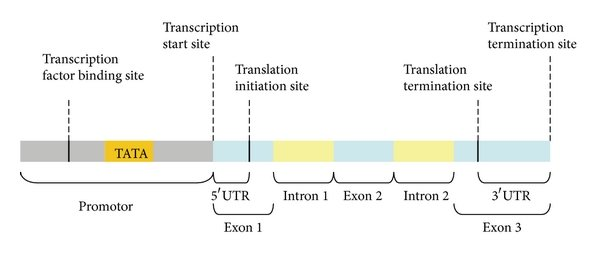



#### **Implementation**

##### **Imports**

In [119]:
# Installations
!pip install biopython
!pip install requests

# Import
import requests
from Bio import SeqIO
from io import StringIO
import numpy as np
from collections import Counter
from itertools import product
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


##### **Loading the Dataset**

In [120]:
def fetch_sequence(url):
    """ Fetches sequences from a url and returns them as a Biopython SeqIO iterator"""
    response = requests.get(url)
    fasta_sequences = SeqIO.parse(StringIO(response.text), 'fasta')
    return list(fasta_sequences)


# URLS from CNNPromoterData on GitHub for the FASTA files
urls = {
    'positive_tata': 'https://raw.githubusercontent.com/solovictor/CNNPromoterData/refs/heads/master/Arabidopsis_tata.fa',
    'positive_non_tata': 'https://raw.githubusercontent.com/solovictor/CNNPromoterData/refs/heads/master/Arabidopsis_non_tata.fa',
    'negative_non_prom': 'https://raw.githubusercontent.com/solovictor/CNNPromoterData/refs/heads/master/Arabidopsis_non_prom_big.fa'
}

# fetch sequences
sequences = {key: fetch_sequence(url) for key, url in urls.items()}

##### **Data Encoding**

In [121]:
def get_kmers(sequence, k=4):
    """ Generates k-mers from a sequence"""
    return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]

def kmer_frequencies(sequences, k=4):
    """ Calculates the k-mer frequencies for a list of sequences """
    kmer_freq_list = []
    for seq in sequences:
        kmers = get_kmers(str(seq.seq), k)
        kmer_count = Counter(kmers)
        total_kmers = sum(kmer_count.values())
        kmer_freq = {kmer: count / total_kmers for kmer, count in kmer_count.items()}
        kmer_freq_list.append(kmer_freq)
    return kmer_freq_list

kmer_freq_positive_tata = kmer_frequencies(sequences['positive_tata'], k=4)
kmer_freq_positive_non_tata = kmer_frequencies(sequences['positive_non_tata'], k=4)
kmer_frequencies_negative_non_prom = kmer_frequencies(sequences['negative_non_prom'], k=4)

In [122]:
def prepare_kmer_vectors(frequencies, all_kmers):
    """ Converts k-mer frequency dictionaries into a fixed-size vector. """
    vectorized_data = []
    for freq in frequencies:
        vector = [freq.get(kmer, 0) for kmer in all_kmers]
        vectorized_data.append(vector)
    return np.array(vectorized_data)

# Generate all possible k-mers for k=4 (4^4 = 256)
possible_kmers = [''.join(p) for p in product('ACGT', repeat=4)]

# Prepare vectors for both positive and negative datasets
vectors_positive_tata = prepare_kmer_vectors(kmer_freq_positive_tata, possible_kmers)
vectors_negative_non_prom = prepare_kmer_vectors(kmer_frequencies(sequences['negative_non_prom'], k=4), possible_kmers)


##### **Understanding the Data**

**Class Distribution**

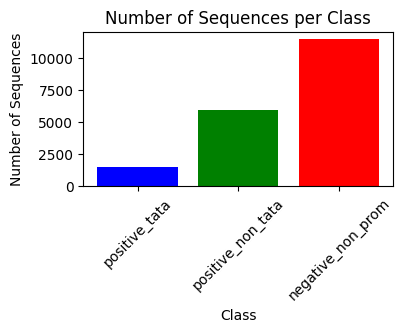

In [123]:
sequence_counts = {key: len(seq_list) for key, seq_list in sequences.items()}

def plot_class_distribution(counts):
    """ Plots a bar chart of sequence counts. """
    categories = list(counts.keys())
    counts = list(counts.values())

    plt.figure(figsize=(4, 2))
    plt.bar(categories, counts, color=['blue', 'green', 'red'])
    plt.title('Number of Sequences per Class')
    plt.xlabel('Class')
    plt.ylabel('Number of Sequences')
    plt.xticks(rotation=45)
    plt.show()

# plot
plot_class_distribution(sequence_counts)

Reviewing the plot shows that there is a class imbalance among the datasets for the CNN promoter data. The `negative_non_prom` class is overrepresented in comparison to the `positive_tata` and `positive_non_tata`.

**Visualization - t-SNE**

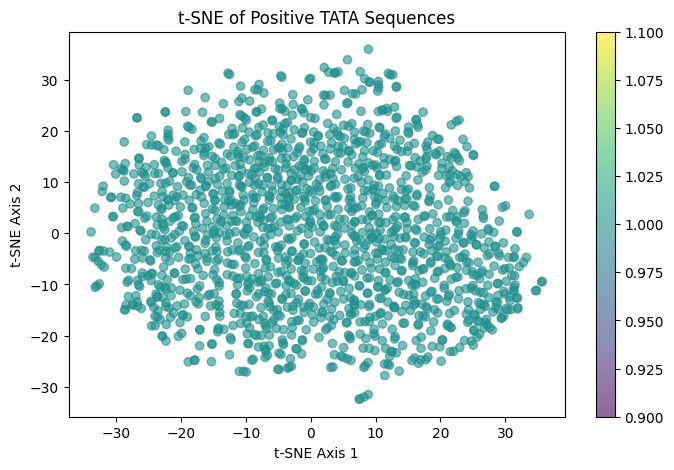

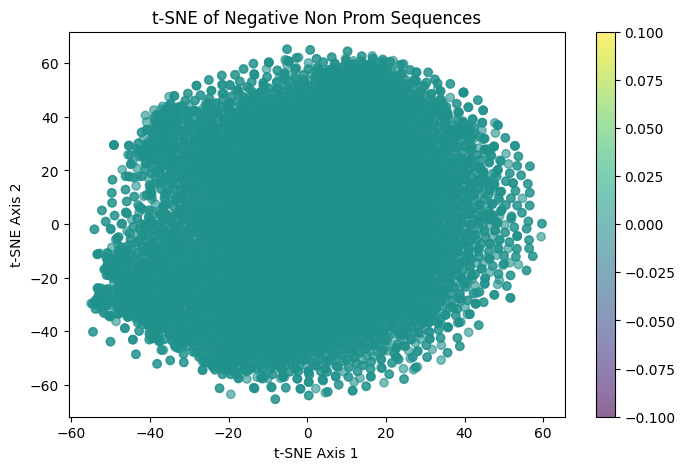

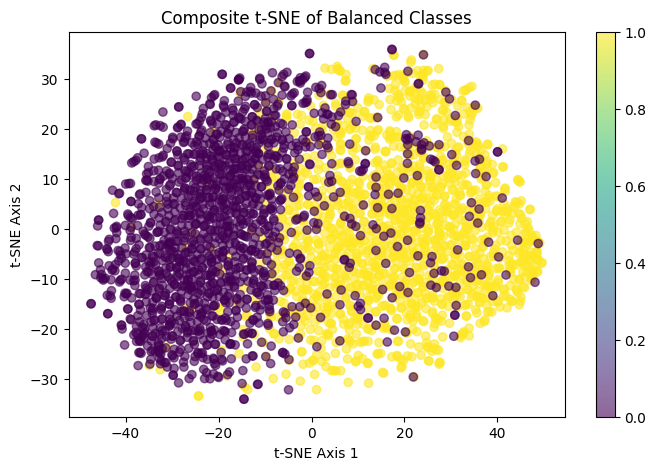

t-SNE with Perplexity: 5 and Learning Rate: 10


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


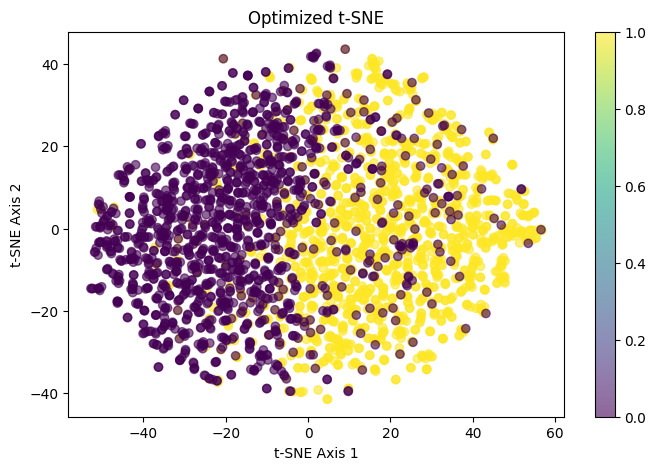

t-SNE with Perplexity: 5 and Learning Rate: 200


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


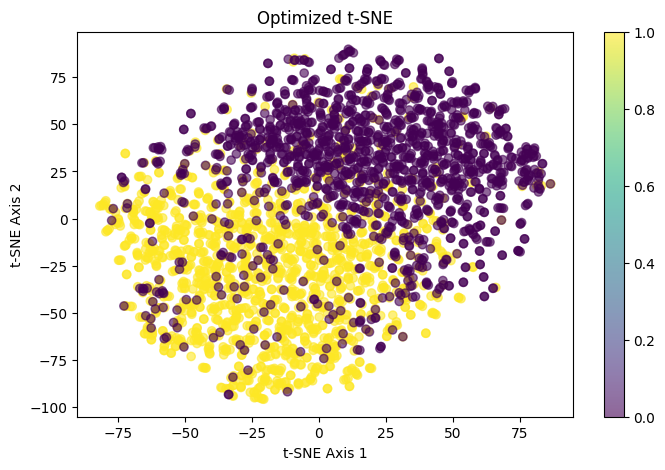

t-SNE with Perplexity: 5 and Learning Rate: 500


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


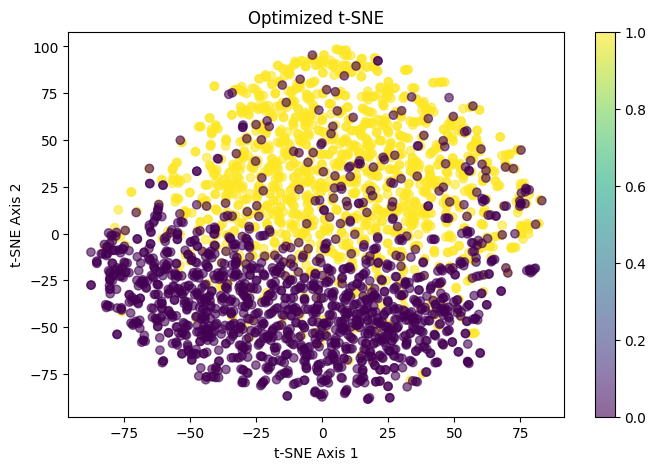

t-SNE with Perplexity: 30 and Learning Rate: 10


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


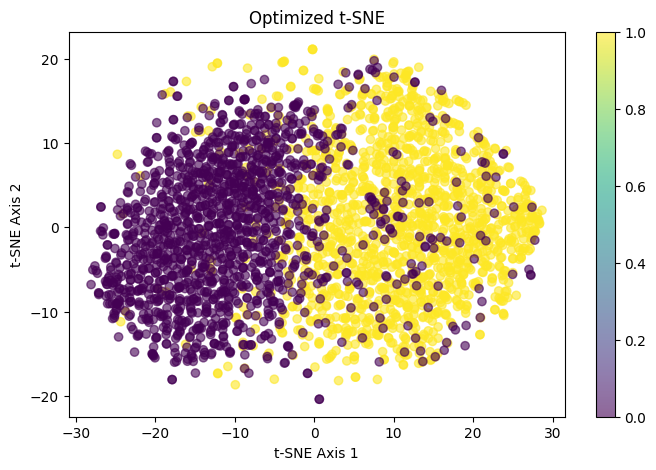

t-SNE with Perplexity: 30 and Learning Rate: 200


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


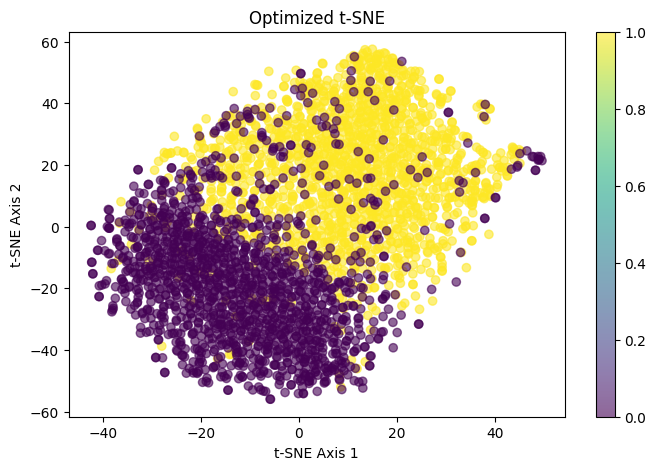

t-SNE with Perplexity: 30 and Learning Rate: 500


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


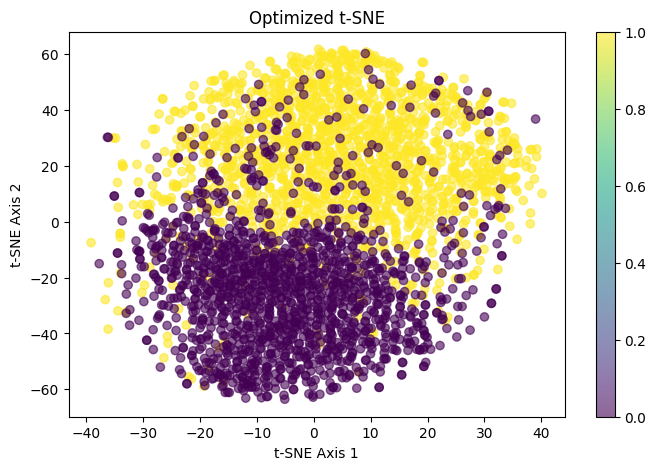

t-SNE with Perplexity: 50 and Learning Rate: 10


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


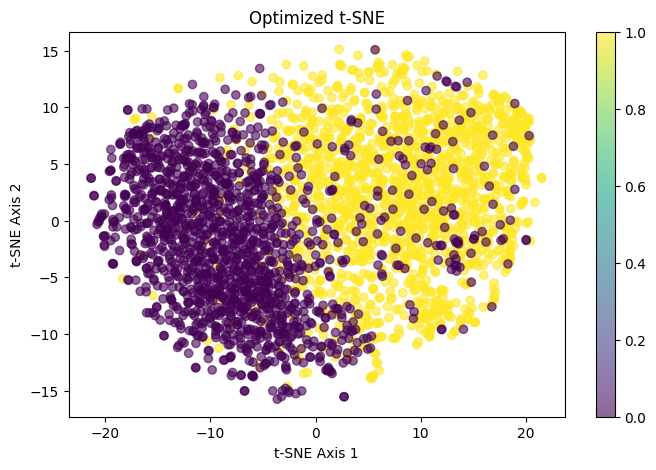

t-SNE with Perplexity: 50 and Learning Rate: 200


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


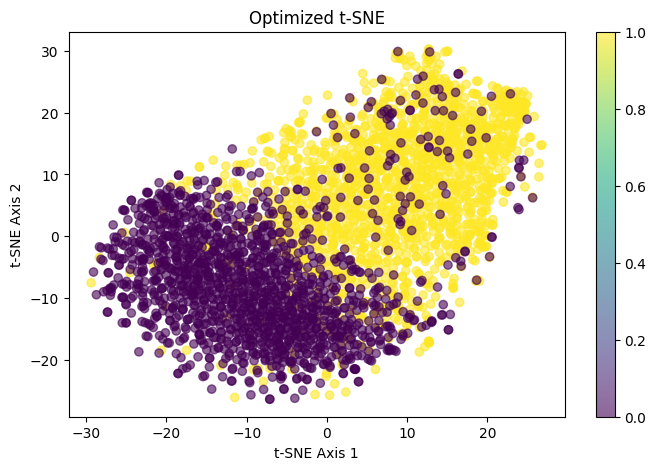

t-SNE with Perplexity: 50 and Learning Rate: 500


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


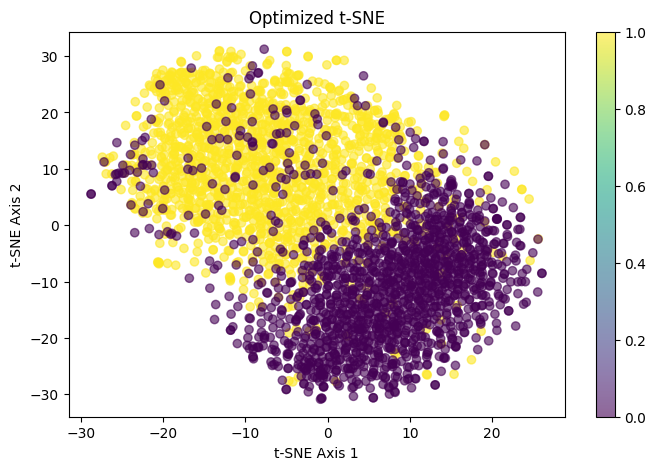

t-SNE with Perplexity: 100 and Learning Rate: 10


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


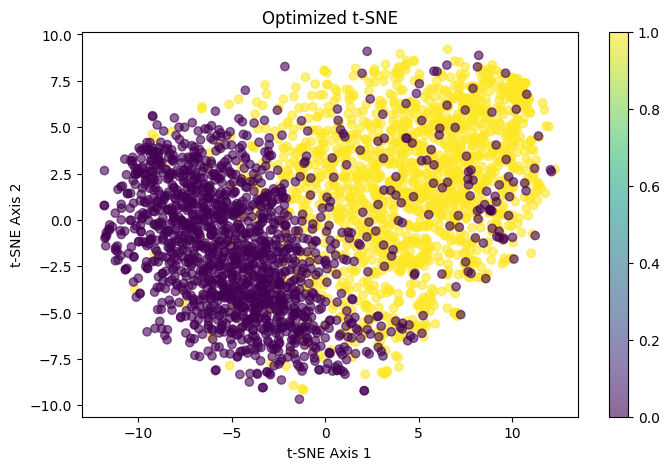

t-SNE with Perplexity: 100 and Learning Rate: 200


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


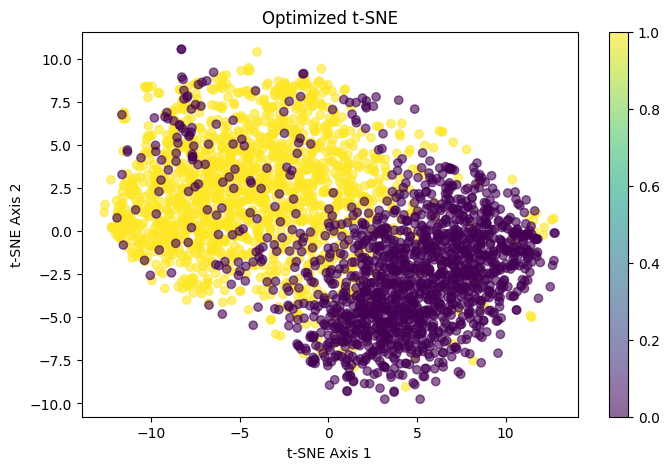

t-SNE with Perplexity: 100 and Learning Rate: 500


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


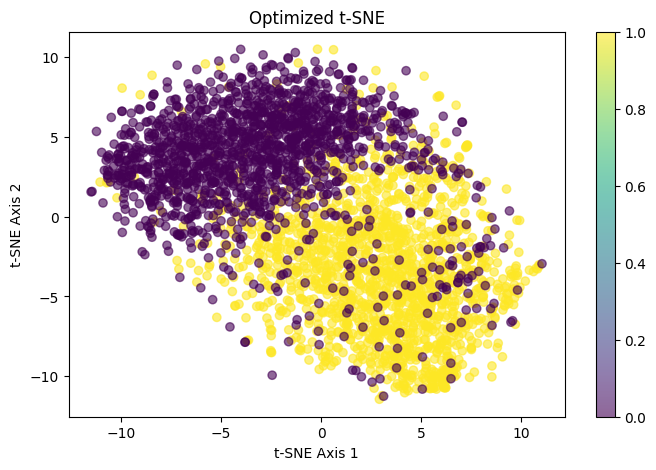

In [124]:
def perform_tsne_and_plot(data, labels, title="t-SNE Plot"):
    """ Performs t-SNE and plots the results. """
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, early_exaggeration=12)
    tsne_results = tsne.fit_transform(data)

    plt.figure(figsize=(8, 5))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.title(title)
    plt.colorbar(scatter)
    plt.xlabel('t-SNE Axis 1')
    plt.ylabel('t-SNE Axis 2')
    plt.show()

def optimized_tsne_and_plot(data, labels, perplexity=40, learning_rate=200, n_iter=1000, title="Optimized t-SNE"):
    """ Performs t-SNE and plots the results with user defined parameters. """
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter, random_state=42)
    tsne_results = tsne.fit_transform(data)

    plt.figure(figsize=(8, 5))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.title(title)
    plt.colorbar(scatter)
    plt.xlabel('t-SNE Axis 1')
    plt.ylabel('t-SNE Axis 2')
    plt.show()

def undersample_data(data, labels, n_samples=None):
    """ Undersample the data so that both classes have the same number of samples. """
    # find the number of samples in minority class, if not specified
    if n_samples is None:
        unique, counts = np.unique(labels, return_counts=True)
        n_samples = min(counts)

    # indices for each class
    indices_positive = [i for i, label in enumerate(labels) if label == 1]
    indices_negative = [i for i, label in enumerate(labels) if label == 0]

    # Randomly select n_samples from each class
    sampled_indices_positive = np.random.choice(indices_positive, n_samples, replace=False)
    sampled_indices_negative = np.random.choice(indices_negative, n_samples, replace=False)

    # Combine the indices and extract the samples
    sampled_indices = np.hstack((sampled_indices_positive, sampled_indices_negative))
    undersampled_data = data[sampled_indices]
    undersampled_labels = [labels[i] for i in sampled_indices]

    return undersampled_data, undersampled_labels


# -------- VISUALIZATION for Positive and Negative -----------

# Generate labels for the plot
labels_positive = [1] * len(vectors_positive_tata)
labels_negative = [0] * len(vectors_negative_non_prom)

# combine the data for a composite graph
combined_data = np.vstack((vectors_positive_tata, vectors_negative_non_prom))
combined_labels = labels_positive + labels_negative

# plot
perform_tsne_and_plot(vectors_positive_tata, labels_positive, "t-SNE of Positive TATA Sequences")
perform_tsne_and_plot(vectors_negative_non_prom, labels_negative, "t-SNE of Negative Non Prom Sequences")

# ------ Undersampling and Visualization for combined Positive and Negative ----------

# Apply undersampling before t-SNE visualization
n_samples = min(len(vectors_positive_tata), len(vectors_negative_non_prom))
undersampled_data, undersampled_labels = undersample_data(combined_data, combined_labels, n_samples=n_samples)

# Perform t-SNE and plot the undersampled data
perform_tsne_and_plot(undersampled_data, undersampled_labels, "Composite t-SNE of Balanced Classes")

# Try different parameters
perplexity_values = [5, 30, 50, 100]
learning_rate_values = [10, 200, 500]

# Loop over a combination to find the best result
for perplexity in perplexity_values:
    for learning_rate in learning_rate_values:
        print(f"t-SNE with Perplexity: {perplexity} and Learning Rate: {learning_rate}")
        optimized_tsne_and_plot(undersampled_data, undersampled_labels, perplexity=perplexity, learning_rate=learning_rate)


There seems to be an overlap among the the two classes, however, taking advantage of the `perplexity` and `early_exaggeration` helps the emergence of two distinct clusters.

#### **Data Partioning**

In [125]:
# using 'undersampled_data and 'undersampled_labels' -> allocating 20% of the data specifically for testing purposes.
X_train, X_test, y_train, y_test = train_test_split(undersampled_data, undersampled_labels, test_size=0.2, random_state=42)
print(f"Training data size: {len(X_train)}, Testing data size: {len(X_test)}")

Training data size: 2395, Testing data size: 599


#### **Training and Testing**

In [126]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

predictions = model.predict(X_test) # predictions on the test set

# classification report and confusion matrix
print(classification_report(y_test, predictions))
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))


              precision    recall  f1-score   support

           0       0.86      0.89      0.87       300
           1       0.89      0.85      0.87       299

    accuracy                           0.87       599
   macro avg       0.87      0.87      0.87       599
weighted avg       0.87      0.87      0.87       599

Confusion Matrix:
[[267  33]
 [ 44 255]]


The model seems to be perfoming well. Precision and Recall metrics are high and f1-score is balanced among both classes. There are some areas of improvement, reducing the number of false positive and false negative to boost further precision and recall.

#### **References**

[1] Nature Education. (n.d.). Promoter. Scitable. Retrieved February 2025, from https://www.nature.com/scitable/definition/promoter-259/ <BR>

[2] StatQuest with Josh Starmer. (n.d.). t-SNE, Clearly Explained [Video]. YouTube. Retrieved from https://www.youtube.com/watch?v=NEaUSP4YerM&t=123s.

[3] OpenAI. (2025). ChatGPT: Advanced AI model by OpenAI. Utilized for problem solving, debugging, testing, and code development assistance in the Recognition of Prokaryotic and Eukaryotic Promoters Using Machine Learning project.

[4] DataCamp. (n.d.). Introduction to t-SNE. Retrieved from https://www.datacamp.com/tutorial/introduction-t-sne.

[5] Built In. (n.d.). Using T-SNE in Python to Visualize High-Dimensional Data Sets. Retrieved from https://builtin.com/data-science/tsne-python